# Description

Generates the figure for top cell types for a specified LV (in Settings section below).

# Modules loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data.recount2 import LVAnalysis
from utils import chunker
import conf

# Settings

In [3]:
LV_NAME = "LV206"

In [4]:
LV_AXIS_THRESHOLD = 3.0
N_TOP_SAMPLES = 400
N_TOP_ATTRS = 25

In [5]:
OUTPUT_FIGURES_DIR = Path(
    conf.MANUSCRIPT["FIGURES_DIR"], "lvs_analysis", f"{LV_NAME.lower()}"
).resolve()
display(OUTPUT_FIGURES_DIR)
OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv206')

In [6]:
OUTPUT_CELL_TYPE_FILEPATH = OUTPUT_FIGURES_DIR / f"{LV_NAME.lower()}-cell_types.svg"
display(OUTPUT_CELL_TYPE_FILEPATH)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv206/lv206-cell_types.svg')

# Load MultiPLIER summary

In [7]:
multiplier_model_summary = pd.read_pickle(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [8]:
multiplier_model_summary.shape

(2157, 5)

In [9]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


# Load data

## Original data

In [10]:
INPUT_SUBSET = "z_score_std"

In [11]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [12]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/bases_data/base_orig/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [13]:
data = pd.read_pickle(input_filepath)

In [14]:
data.shape

(3752, 987)

In [15]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.695006,1.962565,0.057683,0.878731,-0.539977,1.481272,-0.396422,1.090180,0.759223,0.931395,...,1.129784,1.752343,-1.411403,2.823863,0.931116,-1.054519,0.432982,-0.633597,0.554279,-0.642479
100002_raw-Energy,-1.528127,-0.345309,-0.148953,-0.242060,0.373427,0.791092,0.263477,0.987702,0.354391,1.416059,...,0.224604,0.769882,-0.509482,0.091153,2.286789,-1.008256,-0.029764,1.737229,-0.272107,-0.526125
100003_raw-Protein,-0.704572,-1.011299,0.671420,0.143991,0.615212,0.874212,-0.040998,0.915170,0.254369,-0.084237,...,1.003019,1.044314,-2.376108,0.004778,0.053714,-0.892447,-0.183800,1.377991,-0.278794,-0.419733
100004_raw-Fat,-0.989832,-1.875490,0.261555,-1.420719,0.366238,1.167049,0.257387,0.717674,-0.997664,0.969825,...,0.585913,0.638314,0.119139,-0.140204,1.394326,-1.173402,0.555058,1.013982,-0.544506,-0.064061
100005_raw-Carbohydrate,-0.580143,0.243335,0.158966,-0.036558,0.068176,-0.202639,1.101281,0.675227,1.463432,1.010078,...,-0.249108,-0.026814,0.232713,0.323682,1.168642,-0.282935,0.653105,1.909526,0.199997,-1.656894


## LV data

In [16]:
lv_obj = LVAnalysis(LV_NAME, data)

In [17]:
multiplier_model_summary[
    multiplier_model_summary["LV index"].isin((LV_NAME[2:],))
    & (
        (multiplier_model_summary["FDR"] < 0.05)
        | (multiplier_model_summary["AUC"] >= 0.75)
    )
]

[2021-08-02 22:20:46,584 - numexpr.utils] INFO: NumExpr defaulting to 8 threads.


,pathway,LV index,AUC,p-value,FDR


In [18]:
lv_data = lv_obj.get_experiments_data()

SRP042161, SRP055569, SRP033369, SRP002487, SRP038963, SRP014428, SRP058773, SRP066834, SRP060416, SRP011054, SRP018853, SRP033135, SRP059170, SRP064464, SRP057196, SRP009266, SRP020493, SRP042218, SRP051485, SRP009659, SRP006970, SRP063840, SRP059775, SRP050499, SRP062177, SRP060708, SRP066956, SRP018242, SRP009862, SRP059379, SRP018838, SRP009790, SRP011185, SRP060370, SRP017933, SRP055153, SRP057074, SRP030617, SRP063059, SRP046749, SRP040292, SRP015976, SRP014620, SRP058667, SRP013239, SRP019240, SRP010350, SRP012461, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (46 != 48)
  warnings.warn(


In [19]:
lv_data.shape

(5700, 73)

In [20]:
lv_data.head()

cell line     cell type patient id subtype  \
project   run                                                     
SRP042161 SRR1294536       NaN  Glioblastoma      MGH26     NaN   
          SRR1294537       NaN  Glioblastoma      MGH26    None   
          SRR1294538       NaN  Glioblastoma      MGH26     NaN   
          SRR1294539       NaN  Glioblastoma      MGH26     NaN   
          SRR1294540       NaN  Glioblastoma      MGH26     NaN   

                     crosslinker and crosslinking wavelength antibody  \
project   run                                                           
SRP042161 SRR1294536                                     NaN      NaN   
          SRR1294537                                     NaN      NaN   
          SRR1294538                                     NaN      NaN   
          SRR1294539                                     NaN      NaN   
          SRR1294540                                     NaN      NaN   

                     antibody vendor antibody catalog #  \
project   run                                             
SRP042161 SRR1294536             NaN                NaN   
          SRR1294537             NaN                NaN   
          SRR1294538             NaN                NaN   
          SRR1294539             NaN                NaN   
          SRR1294540             NaN                NaN   

                     immunoprecipitated protein weight of protein recovered  \
project   run                                                                 
SRP042161 SRR1294536                        NaN                         NaN   
          SRR1294537                        NaN                         NaN   
          SRR1294538                        NaN                         NaN   
          SRR1294539                        NaN                         NaN   
          SRR1294540                        NaN                         NaN   

                      ... ip antibody antibody used for sorting tissue type  \
project   run         ...                                                     
SRP042161 SRR1294536  ...         NaN                       NaN         NaN   
          SRR1294537  ...         NaN                       NaN         NaN   
          SRR1294538  ...         NaN                       NaN         NaN   
          SRR1294539  ...         NaN                       NaN         NaN   
          SRR1294540  ...         NaN                       NaN         NaN   

                     tissue subtype  tag treatment time  \
project   run                                             
SRP042161 SRR1294536            NaN  NaN            NaN   
          SRR1294537            NaN  NaN            NaN   
          SRR1294538            NaN  NaN            NaN   
          SRR1294539            NaN  NaN            NaN   
          SRR1294540            NaN  NaN            NaN   

                     cardioglycoside treatment  day patient code name  \
project   run                                                           
SRP042161 SRR1294536                       NaN  NaN               NaN   
          SRR1294537                       NaN  NaN               NaN   
          SRR1294538                       NaN  NaN               NaN   
          SRR1294539                       NaN  NaN               NaN   
          SRR1294540                       NaN  NaN               NaN   

                         LV206  
project   run                   
SRP042161 SRR1294536 -0.017402  
          SRR1294537 -0.029225  
          SRR1294538 -0.001296  
          SRR1294539  0.044173  
          SRR1294540  0.066991  

[5 rows x 73 columns]

# LV cell types analysis

## Get top attributes

In [21]:
lv_attrs = lv_obj.get_attributes_variation_score()
display(lv_attrs.head(20))

patient id                                 0.190131
pasaages                                   0.070026
clip antibody vendor                       0.070026
clip antibody                              0.070026
clip antibody cat. #                       0.070026
cell type                                  0.035608
overexpression                             0.013178
antibody                                   0.010064
antibody catalog #                         0.009106
crosslinker and crosslinking wavelength    0.009106
antibody vendor                            0.009106
immunoprecipitated protein                 0.009106
weight of protein recovered                0.009106
age (yrs)                                  0.003468
cohort                                     0.003468
reprogramming time point (day)             0.003163
well number                                0.003163
facs gating                                0.002560
tonsil donor                               0.002560
genotype/var

In [22]:
# show those with cell type or tissue in their name
_tmp = pd.Series(lv_attrs.index)
lv_attrs[
    _tmp.str.match(
        "(?:cell.+type$)|(?:tissue$)|(?:tissue.+type$)",
        case=False,
        flags=re.IGNORECASE,
    ).values
].sort_values(ascending=False)

cell type         0.035608
tissue            0.001812
tissue type       0.001290
tissue subtype    0.001290
dtype: float64

In [23]:
_tmp = lv_data.loc[
    :,
    [
        "cell type",
        "tissue",
        "tissue type",
        "tissue subtype",
        "cell line",
        LV_NAME,
    ],
]

In [24]:
_tmp_seq = list(chunker(_tmp.sort_values(LV_NAME, ascending=False), 25))

In [25]:
_tmp_seq[1]

cell type  \
project   run                                                             
SRP060416 SRR2088399                       tonsil Innate lymphoid cells   
SRP055569 SRR1821489  mixture of U87 human glioma cells and MCF10a h...   
SRP060416 SRR2088078                       tonsil Innate lymphoid cells   
SRP055569 SRR1821445  mixture of U87 human glioma cells and MCF10a h...   
SRP042161 SRR1294639                                       Glioblastoma   
SRP055569 SRR1821444  mixture of U87 human glioma cells and MCF10a h...   
SRP066834 SRR2967806                                                NaN   
SRP060416 SRR2088076                       tonsil Innate lymphoid cells   
          SRR2088230                       tonsil Innate lymphoid cells   
SRP055569 SRR1821455  mixture of U87 human glioma cells and MCF10a h...   
SRP059170 SRR2052647                                   sorted CD4- ILC1   
SRP042161 SRR1294524                                       Glioblastoma   
SRP064464 SRR2558156                                                NaN   
SRP060416 SRR2088251                       tonsil Innate lymphoid cells   
          SRR2088168                       tonsil Innate lymphoid cells   
SRP058773 SRR2042650                                                NaN   
SRP057196 SRR1974708                                             hybrid   
SRP042161 SRR1294972                                       Glioblastoma   
          SRR1295338                             Gliomasphere Cell Line   
SRP060416 SRR2088103                       tonsil Innate lymphoid cells   
SRP057196 SRR1974774                                        endothelial   
SRP002487 SRR048971                                                 NaN   
SRP055569 SRR1821677                   MCF10a human breast cancer cells   
SRP066834 SRR2967492                                                NaN   
SRP055569 SRR2019188  mixture of U87 human glioma cells and WI-38 hu...   

                                                                 tissue  \
project   run                                                             
SRP060416 SRR2088399                                                NaN   
SRP055569 SRR1821489                                                NaN   
SRP060416 SRR2088078                                                NaN   
SRP055569 SRR1821445                                                NaN   
SRP042161 SRR1294639                                                NaN   
SRP055569 SRR1821444                                                NaN   
SRP066834 SRR2967806                                    Fetal neocortex   
SRP060416 SRR2088076                                                NaN   
          SRR2088230                                                NaN   
SRP055569 SRR1821455                                                NaN   
SRP059170 SRR2052647                                   Peripheral blood   
SRP042161 SRR1294524                                                NaN   
SRP064464 SRR2558156                                                NaN   
SRP060416 SRR2088251                                                NaN   
          SRR2088168                                                NaN   
SRP058773 SRR2042650                                                NaN   
SRP057196 SRR1974708                                             cortex   
SRP042161 SRR1294972                                                NaN   
          SRR1295338                                                NaN   
SRP060416 SRR2088103                                                NaN   
SRP057196 SRR1974774                                             cortex   
SRP002487 SRR048971                                                 NaN   
SRP055569 SRR1821677                                                NaN   
SRP066834 SRR2967492  Microdissected cortical-like ventricle from ce...   
SRP055569 SRR2019188                                                NaN   

          

In [26]:
# what is there in these projects?
lv_data.loc[["SRP058773"]].dropna(how="all", axis=1).sort_values(
    LV_NAME, ascending=False
).sort_values(LV_NAME, ascending=False).head(10)

well number reprogramming time point (day)     LV206
project   run                                                            
SRP058773 SRR2042612          38                             10  0.319167
          SRR2042650          10                             10  0.195800
          SRR2042614          23                             10  0.051475
          SRR2042647           6                             10  0.045233
          SRR2042636          54                             10  0.038847
          SRR2042632          58                             10  0.032983
          SRR2042645          27                             10  0.023511
          SRR2042613          76                             10  0.022527
          SRR2042639          68                             10  0.012573
          SRR2042629          92                             10  0.011489

In [27]:
SELECTED_ATTRIBUTE = "cell type"

In [28]:
# it has to be in the order desired for filling nans in the SELECTED_ATTRIBUTE
SECOND_ATTRIBUTES = ["tissue", "cell line"]

## Get plot data

In [29]:
plot_data = lv_data.loc[:, [SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES + [LV_NAME]]

In [30]:
# if blank/nan, fill cell type column with tissue content
_new_column = plot_data[[SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES].fillna(
    method="backfill", axis=1
)[SELECTED_ATTRIBUTE]
plot_data[SELECTED_ATTRIBUTE] = _new_column
plot_data = plot_data.drop(columns=SECOND_ATTRIBUTES)
plot_data = plot_data.fillna({SELECTED_ATTRIBUTE: "NOT CATEGORIZED"})
# plot_data = plot_data.dropna(subset=[SELECTED_ATTRIBUTE])

In [31]:
plot_data = plot_data.sort_values(LV_NAME, ascending=False)

In [32]:
plot_data.head(20)

cell type  \
project   run                                                             
SRP042161 SRR1294848                                       Glioblastoma   
SRP055569 SRR2018987                   MCF10a human breast cancer cells   
SRP033369 SRR1146548                                            HEK293T   
SRP042161 SRR1294847                                       Glioblastoma   
SRP055569 SRR1821487  mixture of U87 human glioma cells and MCF10a h...   
          SRR1821580  mixture of U87 human glioma cells and MCF10a h...   
          SRR2018982  mixture of U87 human glioma cells and MCF10a h...   
SRP002487 SRR048975                                             HEK 293   
SRP055569 SRR1821364                             U87 human glioma cells   
SRP038963 SRR1176917                   Glioblastoma (Astrocytoma) cells   
SRP014428 SRR522080          leukocyte from blood of healthy individual   
SRP042161 SRR1294996                                       Glioblastoma   
SRP002487 SRR048968                                             HEK 293   
SRP058773 SRR2042612                                    NOT CATEGORIZED   
SRP066834 SRR2967763                                    Fetal neocortex   
SRP055569 SRR2019049                             U87 human glioma cells   
SRP060416 SRR2088204                       tonsil Innate lymphoid cells   
SRP011054 SRR413944                                              HCT116   
SRP055569 SRR1821659                   MCF10a human breast cancer cells   
          SRR1821584  mixture of U87 human glioma cells and MCF10a h...   

                          LV206  
project   run                    
SRP042161 SRR1294848  11.281049  
SRP055569 SRR2018987   0.885504  
SRP033369 SRR1146548   0.774964  
SRP042161 SRR1294847   0.604154  
SRP055569 SRR1821487   0.594659  
          SRR1821580   0.509572  
          SRR2018982   0.484882  
SRP002487 SRR048975    0.429455  
SRP055569 SRR1821364   0.406834  
SRP038963 SRR1176917   0.370962  
SRP014428 SRR522080    0.368821  
SRP042161 SRR1294996   0.363662  
SRP002487 SRR048968    0.344013  
SRP058773 SRR2042612   0.319167  
SRP066834 SRR2967763   0.305560  
SRP055569 SRR2019049   0.297817  
SRP060416 SRR2088204   0.274310  
SRP011054 SRR413944    0.272949  
SRP055569 SRR1821659   0.265009  
          SRR1821584   0.262654

## Customize x-axis values

When cell type values are not very clear, customize their names by looking at their specific studies to know exactly what the authors meant.

In [33]:
final_plot_data = plot_data.replace(
    {
        SELECTED_ATTRIBUTE: {
            # SRP057196
            "fetal_quiescent": "Fetal neurons (quiescent)",
            "fetal_replicating": "Fetal neurons (replicating)",
            # SRP055569
            "mixture of U87 human glioma cells and WI-38 human lung fibroblast cells": "Glioma cells + lung fibroblast cells",
            "mixture of U87 human glioma cells and MCF10a human breast cancer cells": "Glioma cells + breast cancer cells",
        }
    }
)

In [34]:
# # add also tissue information to these projects
_srp_code = "SRP057196"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: x[SELECTED_ATTRIBUTE]
    + f" ({lv_data.loc[(_srp_code, x.name), 'tissue']})",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

<ipython-input-34-26d4d9c15426>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  _tmp = final_plot_data.loc[(_srp_code,)].apply(


In [35]:
# take the top samples only
final_plot_data = final_plot_data.sort_values(LV_NAME, ascending=False)[:N_TOP_SAMPLES]

## Threshold LV values

In [36]:
final_plot_data.loc[
    final_plot_data[LV_NAME] > LV_AXIS_THRESHOLD, LV_NAME
] = LV_AXIS_THRESHOLD

## Delete samples with no tissue/cell type information

In [37]:
final_plot_data = final_plot_data[
    final_plot_data[SELECTED_ATTRIBUTE] != "NOT CATEGORIZED"
]

## Set x-axis order

In [38]:
attr_order = (
    final_plot_data.groupby(SELECTED_ATTRIBUTE)
    .max()
    .sort_values(LV_NAME, ascending=False)
    .index[:N_TOP_ATTRS]
    .tolist()
)

In [39]:
len(attr_order)

25

In [40]:
attr_order[:5]

['Glioblastoma',
 'MCF10a human breast cancer cells',
 'HEK293T',
 'Glioma cells + breast cancer cells',
 'HEK 293']

## Plot

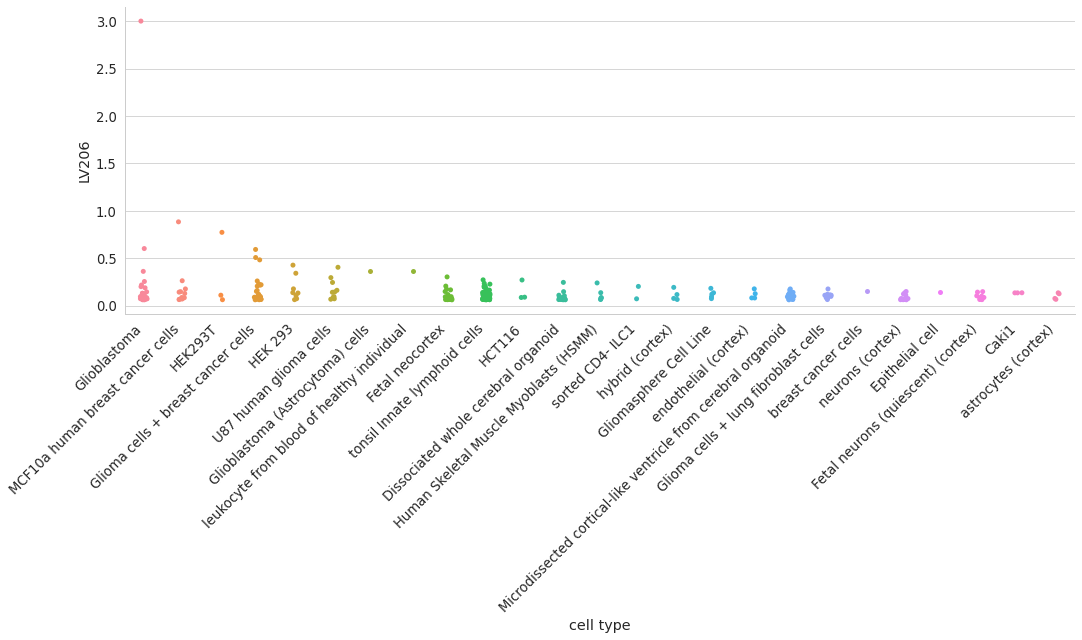

In [41]:
with sns.plotting_context("paper", font_scale=1.5), sns.axes_style("whitegrid"):
    sns.catplot(
        data=final_plot_data,
        y=LV_NAME,
        x=SELECTED_ATTRIBUTE,
        order=attr_order,
        kind="strip",
        height=5,
        aspect=3,
    )
    plt.xticks(rotation=45, horizontalalignment="right")

    plt.savefig(
        OUTPUT_CELL_TYPE_FILEPATH,
        bbox_inches="tight",
        facecolor="white",
    )

# Debug

In [42]:
# with pd.option_context(
#     "display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None
# ):
#     _tmp = final_plot_data[final_plot_data[SELECTED_ATTRIBUTE].str.contains("neurons")]
#     display(_tmp.head(20))

In [43]:
# # what is there in these projects?
# lv_data.loc[["SRP050499"]].dropna(how="all", axis=1).sort_values(
#     LV_NAME, ascending=False
# ).head(60)